In [1]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler,StableDiffusionPipeline
from diffusers.utils import load_image
import torch
import os

/home/swc/AICUP_generative/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# base_model_path = "stabilityai/stable-diffusion-2-1"
base_model_path = "runwayml/stable-diffusion-v1-5"
controlnet_path = "output_sd15_2/checkpoint-6000/controlnet/"

In [12]:
img_type = "river"
prefix_path = f"/home/swc/AICUP_generative/training/{img_type}/train/"
train_path = f"training/{img_type}/train/"
img_path = f"training/{img_type}/train/images/"
conditioning_img_path = f"training/{img_type}/train/conditioning_images/"
img_list = os.listdir(img_path)
img_list.sort()
conditioning_img_list = os.listdir(conditioning_img_path)
conditioning_img_list.sort()

test_path = f"testing/label_img/{img_type}/"
conditioning_test_img_list = os.listdir(test_path)
conditioning_test_img_list.sort()

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
controlnet = ControlNetModel.from_pretrained(
    controlnet_path, torch_dtype=torch.float16
).to(device)
# pipe = StableDiffusionControlNetPipeline.from_pretrained(
#     base_model_path, controlnet=controlnet, torch_dtype=torch.float16
# ).to(device)
pipe = StableDiffusionControlNetPipeline.from_single_file(
    "beautifulrealityv3_full.safetensors",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [15]:
# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed or when using Torch 2.0.
pipe.enable_xformers_memory_efficient_attention()
# memory optimization.
pipe.enable_model_cpu_offload()

# load lora
# pipe.unet.load_attn_procs("sd15_lora/checkpoint-51840/pytorch_lora_weights.safetensors") 

pipe = pipe.to("cuda")

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, controlnet, scheduler, safety_checker, feature_extractor, image_encoder to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


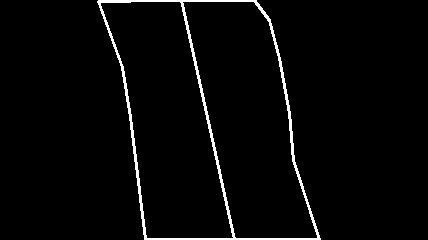

In [19]:
conditioning_img = test_path+conditioning_test_img_list[0]
load_image(conditioning_img)

100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


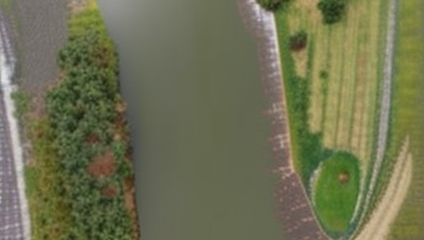

In [22]:
control_image = load_image(conditioning_img)
prompt = "river with muddy and light earth color water, aerial view, field, lush shore, gress"
negative_prompt = "bridge, sand, tall trees, sandbank"
# generate image
generator = torch.manual_seed(2)
image = pipe(
    prompt,negative_prompt=negative_prompt, num_inference_steps=20, generator=generator, image=control_image
).images[0]
image